# Lab Assignment Seven: Sequential Network Architectures
In this lab, you will select a prediction task to perform on your dataset, evaluate a sequential architecture and tune hyper-parameters. If any part of the assignment is not clear, ask the instructor to clarify.

This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

## Dataset Selection

Select a dataset that is text. That is, the dataset should be text data. In terms of generalization performance, it is helpful to have a medium sized dataset of similar sized text documents. It is fine to perform binary classification or multi-class classification. The classification should be "many-to-one" sequence classification.



## Preparation (3 points total)
[1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  
[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.

## Modeling (6 points total)
[3 points] Investigate at least two different sequential network architectures (e.g., a CNN and a Transformer). Alternatively, you may also choose a recurrent network and Transformer network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust one hyper-parameter of each network to potentially improve generalization performance (train a total of at least four models). Visualize the performance of training and validation sets versus the training iterations, showing that the models converged.
[1 points] Using the best parameters and architecture from the Transformer in the previous step, add a second Multi-headed self attention layer to your network. That is, the input to the second attention layer should be the output sequence of the first attention layer.  Visualize the performance of training and validation sets versus the training iterations.
[2 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the models you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

## Exceptional Work (1 points total)
You have free reign to provide additional analyses.
One idea (required for 7000 level students to do one of these options):
Use the pre-trained ConceptNet Numberbatch embedding and compare to pre-trained GloVe. Which method is better for your specific application?

In [3]:
!pip install tensorflow_addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.9 MB/s eta 0:00:00


In [4]:
import subprocess
import platform
import os
import itertools
import time
from IPython.display import display, HTML, Markdown, clear_output

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import (
    utils,
    models,
    layers,
    metrics,
    preprocessing,
    callbacks,
)

from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    make_scorer,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

def clear_screen():
    time.sleep(2)
    print("Clearing screen...")
    time.sleep(2)
    clear_output()

clear_screen()

In [5]:
import pandas as pd
import zipfile
import os
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Selection

https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset


This dataset contains 5,574 English SMS messages labeled as spam or not spam (ham). The dataset contains one message per line. Each line is composed of two columns the label and the textual data. The label in this data set is a binary classifier with results of either ham or spam. Therefore representing a many-to-one relationship. This dataset originally labeled the columns v1 for the label and v2 for the raw text data. To provide readability to our code we changed the column names to be labeled label and text respectively.


Acknowledgments
The original dataset can be found here.

Reference to previous paper: Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.
Reference to web page: http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/


In [50]:
# Read in our dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Lab7_ML/spam 2.csv", encoding='latin1')

# Renaming the columns for readability purposes
df.rename(columns={'v1': 'Label'}, inplace=True)
df.rename(columns={'v2': 'Text'}, inplace=True)

df.head()


,Label,Text,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Dataset Details

No additional features were added.

In [51]:
def print_df_list_of_features():
    columns = df.columns.to_list()
    features = "Features: "
    for i, col in enumerate(columns):
        if i > 0:
            features += f', "{col}"'
        else:
            features += f'"{col}"'
    print(features)

print_df_list_of_features()

Features: "Label", "Text", "Unnamed: 2", "Unnamed: 3", "Unnamed: 4"


In [52]:
# Prints the size of the dataframe to output
rows, columns = df.shape
print(f"The dataset contains {rows} rows and {columns} columns.\n")

The dataset contains 5572 rows and 5 columns.



## Handeling Missing Data

In the cells below you can see that the columns labeled 'Unnamed: 2', 'Unnamed: 3', and 'Unnamed: 4' are ~99.8 % null values.

Due to the extensive amount of null values in these columns, we decided to remove them to avoid unnecessary noise in our dataset. In doing this we will improve our training time by reducing the size of the dataset and increase our model's ability to learn the relationships between features.





In [53]:
missing_values = df.isnull().sum()
print("Missing Values:")
print(str(missing_values)+ "\n")

print("These are the columns with missing data:" + str(df.columns[df.isnull().any()].tolist()))

Missing Values:
Label            0
Text             0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

These are the columns with missing data:['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']


In [54]:
# Prints a list of columns that are filled with null values
# Here you can see there are non-null values in these columns but it is less than 1 % of the data within the entire dataset.
# Therefore our group chose to delete them to improve our models performance.

print(df.columns[df.isnull().all()])

print(df['Unnamed: 2'].str.cat(sep=''))

df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

Index([], dtype='object')
 PO Box 5249 the person is definitely special for u..... But if the person is so special HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE JEN XXX\"" wanted to say hi. HI!!!\" Stop? Send STOP to 62468"this wont even start........ Datz confidence.." PO Box 5249GN.;-):-D"just been in bedbut mite go 2 thepub l8tr if uwana mt up?loads a luv Jenxxx.\"" bt not his girlfrnd... G o o d n i g h t . . .@" I'll come up" don't miss ur best life for anything... Gud nyt..." just as a shop has to give a guarantee on what they sell. B. G." But at d end my love compromised me for everything:-(\".. Gud mornin:-)" the toughest is acting Happy with all unspoken pain inside..\"" smoke hella weed\""\" not \"what i need to do.\""JUST GOT PAYED2DAY & I HAVBEEN GIVEN Aå£50 PAY RISE 4MY WORK & HAVEBEEN MADE PRESCHOOLCO-ORDINATOR 2I AM FEELINGOOD LUV\"" justthought iåÕd sayhey! how u doin?nearly the endof me wk offdam nevamind!We will have 2Hook up sn if uwant m8? loveJen x.\""JUST REALLYNEE

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


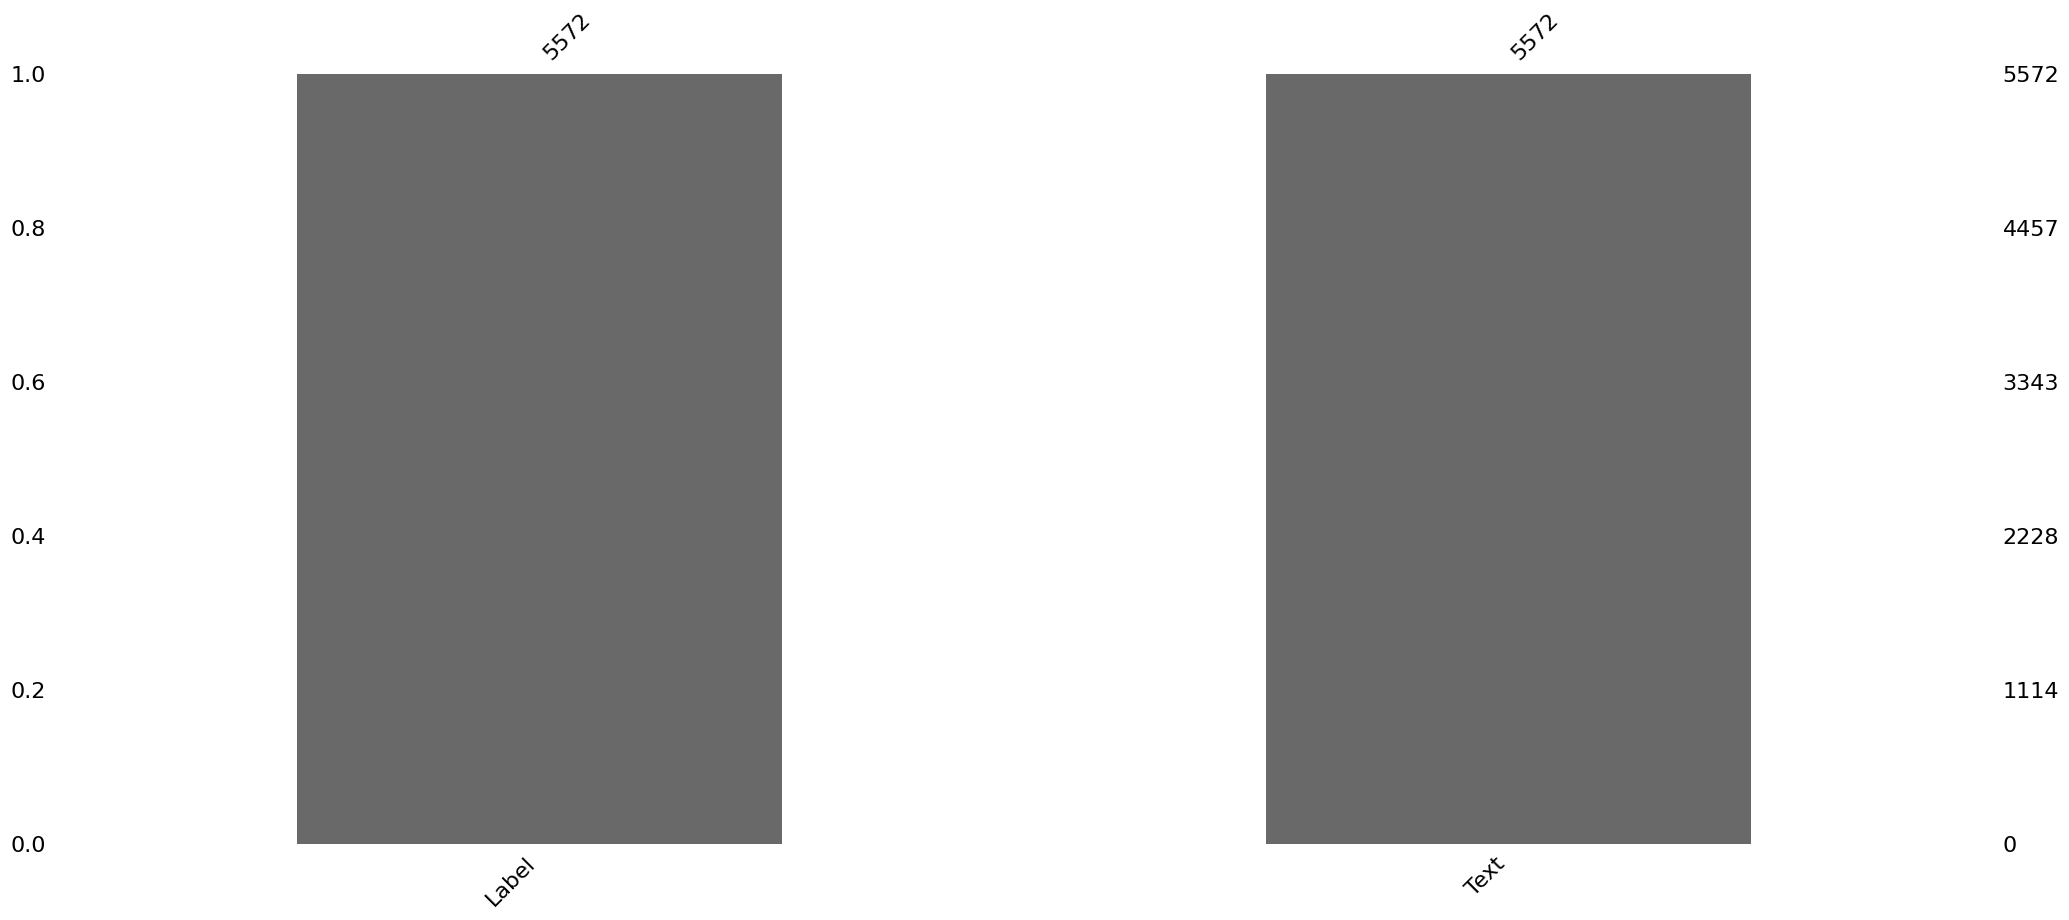

In [55]:
# Final dataset with no missing values.

import missingno as msno

msno.bar(df)

df.head()

## Check for Duplicates


In [56]:
def check_for_duplicate_entries():
    return df.duplicated().any()


print(
    "Duplicates Found!"
) if check_for_duplicate_entries() is True else print("No Duplicates Found!")

No Duplicates Found!


### Dataset Types

In the cell below you can see our dataset is in text format. It will be one hot encoded in the following cells to ensure the ability to run sequential networks!

In [57]:
# Prints the datatypes for each column
print("Datatypes")
print(df.dtypes)

Datatypes
Label    object
Text     object
dtype: object


## Data Preparation

The **first step** in preprocessing our data for sequential networks is to remove any irrelevant information such as **stopwords** and convert all the text to lowercase to ensure consistency. In the cell below you can see we removed the stop words from the Text column in our dataframe.

In [58]:
# Removing stop words from the text column.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!




**The second step is to tokenize the data. **
Tokenizing the data is breaking the text into a sequence of tokens. These tokens are often words or charecters in the dataset. It is important to tokenize a dataset to reduce the dimensionality of the dataset making the network easier to learn! Tokenizing the dataset can also emphasize the important parts of the text which can therefore improve the accuracy of the network's prediction. Lastly, tokenizing the dataset can help improve the stability of a dataset byt making the dataset more consistent.

In the cells below you can see we created a new column called tokenizedText that represents the tokenized version of the SMS data.

In [59]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [60]:
# Funtion returns all tokens in lowercase.
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

In [61]:
# Function return list of tokens from SMS messages column df['Text']
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    tokens = to_lowercase(tokens)
    return [w for w in tokens if w.isalpha()]

In [62]:
df['tokenizedText'] = df.apply(lambda x: tokenize(x['Text']), axis=1)
df[['tokenizedText']].head()

,tokenizedText
0,"[go, jurong, point, crazy, available, bugis, n..."
1,"[ok, lar, joking, wif, u, oni]"
2,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,"[u, dun, say, early, hor, u, c, already, say]"
4,"[nah, i, think, goes, usf, lives, around, though]"


In [17]:
print(df.dtypes)

Label            object
Text             object
tokenizedText    object
dtype: object


**The third step is to force a specific length on our dataset. **
To force a specific length of sequence on your dataset you can use the pad_sequences() function from the keras preprocessing library. This function takes a max length argument and either truncates your sequences or adds zeros to force a specific length on the dataset.

In the cell below we first calculate the longest sequence in our tokenized dataset. The longest sequence in our dataset came out to be 85 tokens. In the cells following we will pad the sequences that have below 85 tokens using the keras preprocessing library!




In [63]:
def getMaxLength(df):
  return max(len(x) for x in df['tokenizedText'])

In [106]:
# Create a tokenizer
# Fit the tokens to the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokenizedText'])

# Convert the text to sequences of integers
x = tokenizer.texts_to_sequences(df['tokenizedText'])

# Get the maximum length of the sequences
max_length = getMaxLength(df)

# Pad the sequences to the maximum length
# So we can send them through a  neural network
padded = pad_sequences(x, maxlen=max_length)

# Print the padded dataset
print(padded)

[[   0    0    0 ...   15 3683   82]
 [   0    0    0 ...  382    2 1686]
 [   0    0    0 ...  132   76  325]
 ...
 [   0    0    0 ...   38  459 7278]
 [   0    0    0 ...  892  149   12]
 [   0    0    0 ...  105  408  204]]


**The last step is to one-hot encode the labels. **

Since our labels are categorical values of spam or not spam (also known as ham) it is important to convert these values to binary values. The label will take on a value of 1 if the vector is spam and a 0 if it is ham.

It is important to one-hot encode categorical values in our dataset to ensure our model can learn the relationship between the different categories.


In [107]:
from keras.utils import to_categorical

# Prints the unique labels
print("These are the unique labels in our dataset. We need to change these values to be one hot encoded. ")
print(df['Label'].nunique())
print(df['Label'].unique())
print()

one_hot_encoded_data = pd.get_dummies(df, columns = ['Label'])
print("This is the new dataset!")
print(one_hot_encoded_data.dtypes)

# one hot encoding labels
#one_hot_labels = to_categorical(df['Label'])

#print(one_hot_labels)



These are the unique labels in our dataset. We need to change these values to be one hot encoded. 
2
['ham' 'spam']

This is the new dataset!
Text             object
tokenizedText    object
Label_binary      int64
Label_ham         uint8
Label_spam        uint8
dtype: object


## Evaluation Method



For evaluating our model's performance, we will be using recall. Between the two types of classifications spam and ham it is important to avoid marking possibly important messages as spam/junk mail. Misclassification of text messages could lead to dissatisfaction and the loss of important information. For example, a missing credit card statement, an appointment reminder, a package delivery, and much more. Therefore our models will be evaluated on their ability to positively classify these messages as spam or ham.

Beyond recall, we use metrics such as accuracy, misclassificaiton, precision, recall, and F1-score to measure and compare algorithm performance.

Accuracy is a measure of the overall correctness of a model's predictions, calculated as the ratio of the number of correct predictions to the total number of predictions.

Misclass, or misclassification, refers to the instances where a model's prediction does not match the actual class label of a data point.

Precision is a measure of how well a model correctly identifies positive instances among the predicted positive instances.

Recall, also known as sensitivity or the true positive rate, is a measure of how well a model identifies all the positive instances among the actual positive instances.

F1-score is the "harmonic mean" of precision and recall, providing a single value that balances the trade-off between precision and recall.


Additionally, we will evaluate the performance of a sequential network based on its training time and computational resources required. It is important to take into consideration the amount of time and resources our models will need because we want to avoid crashing the messaging device while predicting if a message is spam or ham.  


We want to consider all of these metrics since not only do we want our models to perform well, but we want to achieve the highest true positive rate for both classes as possible.

## Dataset Splitting

In the following cells, you can see we used "random split" to split our dataset. This was the most realistic method for our dataset becaues an email inbox is random! There is no method to determine what email you will recieve at a specific time so we decided that randomly splitting our dataset was the most realistic in practice!

Further, you can see we have split our dataset with X as the padded dataset. By using this dataset we ensure each input into the model will be the same length. For y we used the one hot encoded Label ham column from the dataset. Since this is a binary classification we are not required to run y on both the labeled ham and labeled spam!

In [108]:
from sklearn.model_selection import train_test_split

# Features (padded sequences)
X = padded

# Labels (using 'Label_ham' as the label column)
y = one_hot_encoded_data['Label_ham']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


## Sequential Network with CNN Architecture

This model is a Convolutional Neural Network (CNN) designed for text classification. It's aimed at processing textual data and making predictions, particularly in binary classification tasks (where the output is either 0 or 1, typically representing two classes like spam/ham or positive/negative sentiment).

The provided code constructs a Convolutional Neural Network (CNN) named cnn_text with the following architecture:

[1] Embedding layer:

- This layer learns and maps each word in the vocabulary to a high-dimensional vector space.
- This layer helps represent words in a meaningful way, capturing their relationships based on their usage in the dataset.

[2] Conv1D Layer:

 - This layer applies convolutional operations across the embeddings, extracting local patterns or features.
 - It uses 64 filters (kernel_size=3)
 - ReLU activation to capture different aspects of the text.

[3] GlobalMaxPooling1D Layer:

- This layer reduces the dimensionality of the convolutional output by selecting the maximum value from each feature map.

- This pooling operation aggregates the important features from each filter across the input sequence

[4] Dense Layer:

- This layer acts as the output layer, producing a single value (between 0 and 1) which represents spam/ham.

- Single neuron and a sigmoid activation function are added here.


[5] Model Compiled and Evaluation Metrics
- This model is compiled using the  Adam optimizer and binary cross-entropy loss function

- Throughout epochs, the model monitors accuracy as the evaluation metric during training.


Using a Sequential CNN for a spam or ham dataset is not the most common approach. CNN are predominately used for image recognition due to their ability to capture spatial hierarchies in data.

From our research on CNN and textual datasets, it was clear that some textual data contains specific sequences and visual elements such a characters arranged to make an image-like pattern or even HTML files. However, we chose to use it for our dataset due to its rich structural patterns and in hopes of experimenting with the text dataset uniquely.

Since this is our final project our group decided it would be fun to try unconventional architectures on our dataset and explore the results. As you will see in the following cells is a good thing we experimented with architectures because our model was able to perform an innovative feature extraction.

In [67]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# Set the vocabulary size, max length, and embedding dimension
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
max_length = getMaxLength(df)
embedding_dim = 100  # Adjust based on your pre-trained embeddings

# Create the model
cnn_text = Sequential()
cnn_text.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=True))
cnn_text.add(Conv1D(64, kernel_size=3, activation='relu'))
cnn_text.add(GlobalMaxPooling1D())
cnn_text.add(Dense(1, activation='sigmoid'))

cnn_text.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(cnn_text.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 100)           728000    
                                                                 
 conv1d (Conv1D)             (None, 83, 64)            19264     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 747329 (2.85 MB)
Trainable params: 747329 (2.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [68]:
from sklearn.model_selection import train_test_split

# Splitting the padded sequences and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded, one_hot_encoded_data['Label_ham'], test_size=0.25)

# Train the model
cnn_history = cnn_text.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)


Epoch 1/3
131/131 [==============================] - 7s 42ms/step - loss: 0.3279 - accuracy: 0.8816 - val_loss: 0.0986 - val_accuracy: 0.9698
Epoch 2/3
131/131 [==============================] - 5s 42ms/step - loss: 0.0662 - accuracy: 0.9780 - val_loss: 0.0441 - val_accuracy: 0.9892
Epoch 3/3
131/131 [==============================] - 4s 32ms/step - loss: 0.0223 - accuracy: 0.9950 - val_loss: 0.0384 - val_accuracy: 0.9907


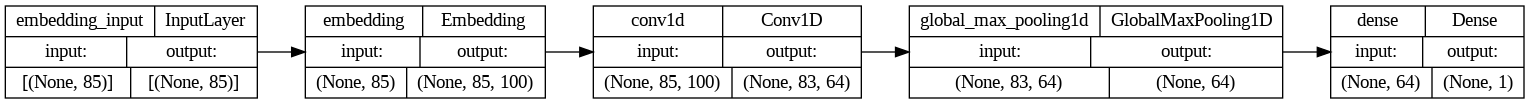

In [69]:
# Plotting the model
from keras.utils import plot_model
plot_model(
    cnn_text,
    to_file="model_text.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

### CNN Model Evaluation and Visualization

In [70]:
# Evaluate the performance of a CNN architecture on a test set by predicting the class
# probabilities and rounding them to obtain class predictions.

# Defines the y-prediction probability and y-prediction arrays
y_predict_proba = cnn_text.predict(X_test)
y_predict = np.round(y_predict_proba)

# Prints classification report
print(classification_report(y_test, y_predict))

class_report = metrics.classification_report(
    y_test, y_predict, output_dict=True
)

44/44 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       186
           1       0.99      1.00      0.99      1207

    accuracy                           0.99      1393
   macro avg       0.98      0.98      0.98      1393
weighted avg       0.99      0.99      0.99      1393



The provided code assesses the performance of an CNN model on a test set by predicting class probabilities and rounding them to obtain class predictions. Subsequently, it prints a classification report containing various performance metrics, such as precision, recall, F1-score, and support for each class, along with their macro and weighted averages.

According to the classification report, the model demonstrates a great level of accuracy, achieving a precision and recall of 0.94 and 0.98 for the classes.
The F1-score is also well performing, reaching 0.92 and 0.99 for the two classes. The support column indicates the number of samples in each class, with class 0 has 196 samples and class 1 has 1197 samples—suggesting an unequal distribution. This also shows having a larger amount of samples leads to an overall higher performance.

 The metrics, including micro avg, macro avg, weighted avg, and samples avg, represent different averaging methods used to calculate performance metrics across all classes.

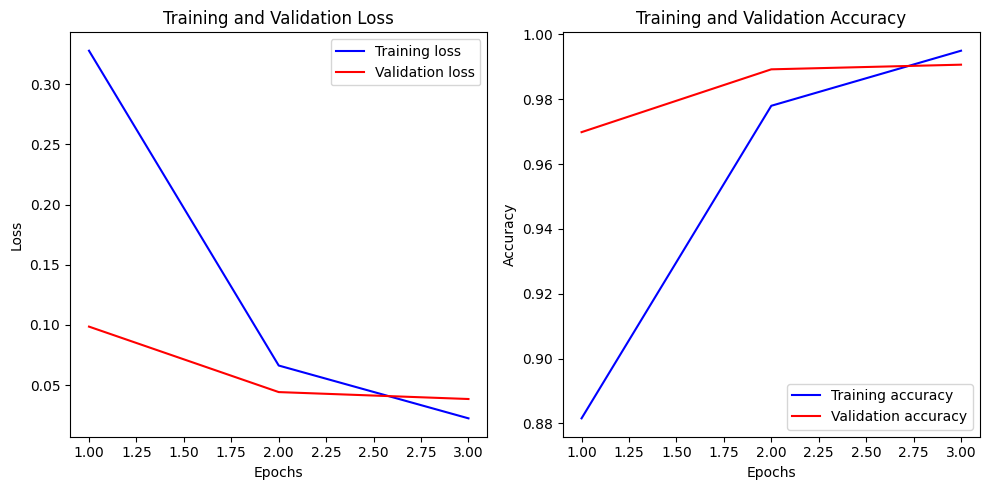

In [72]:
import matplotlib.pyplot as plt

# Get training/validation loss and accuracy from history
train_loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
train_accuracy = cnn_history.history['accuracy']
val_accuracy = cnn_history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

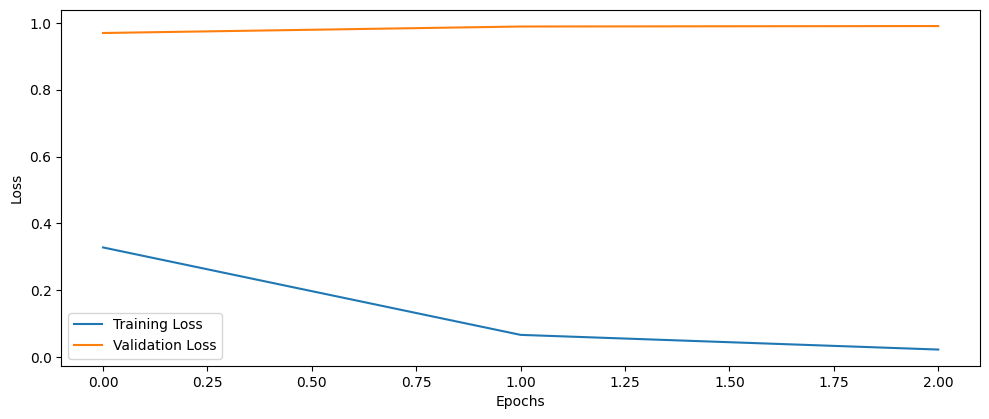

In [73]:
# Plots the training versus testing graph for the MLP model
# Model history values
hist_values = list(cnn_history.history.values())

# Variables for plotting the training versus testing
train_loss   = hist_values[0]
train_recall = hist_values[1]
train_auc    = hist_values[2]
val_loss     = hist_values[3]


# Plots the training versus testing graph
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, (1, 2))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()

plt.show()

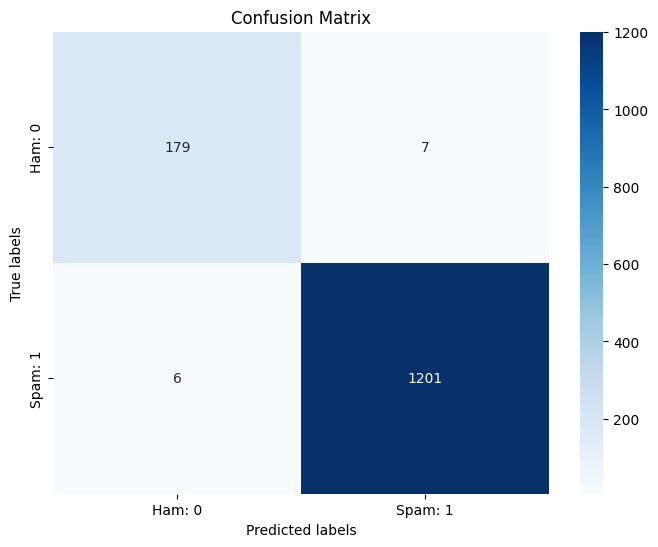

In [74]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham: 0', 'Spam: 1'], yticklabels=['Ham: 0', 'Spam: 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Adding Dropout to Improve CNN Performance


The provided code constructs a Convolutional Neural Network (CNN) named cnn_text2 with the following architecture:

[1] Embedding layer:

- This layer learns and maps each word in the vocabulary to a high-dimensional vector space.
- This layer helps represent words in a meaningful way, capturing their relationships based on their usage in the dataset.

[2] Conv1D Layer:

- This layer applies convolutional operations across the embeddings, extracting local patterns or features.
- It uses 64 filters (kernel_size=3)
- ReLU activation to capture different aspects of the text.

[3] GlobalMaxPooling1D Layer:

- This layer reduces the dimensionality of the convolutional output by selecting the maximum value from each feature map.

- This pooling operation aggregates the important features from each filter across the input sequence

[4]Dropout Layer:
- In this case, the Dropout layer doesn't change the shape of the input.
- It takes an input of shape (None, 64) and outputs the same shape (None, 64) after applying dropout.
- Which proves to be barely helpful to out model.

[5] Dense Layer:

- This layer acts as the output layer, producing a single value (between 0 and 1) which represents spam/ham.

- Single neuron and a sigmoid activation function are added here.


[6] Model Compiled and Evaluation Metrics

- This model is compiled using the Adam optimizer and binary cross-entropy loss function

- Throughout epochs, the model monitors accuracy as the evaluation metric during training.

In [110]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# Set the vocabulary size, max length, and embedding dimension
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
max_length = getMaxLength(df)
embedding_dim = 100  # Adjust based on your pre-trained embeddings

# Create the model
cnn_text2 = Sequential()
cnn_text2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=True))
cnn_text2.add(Conv1D(64, kernel_size=3, activation='relu'))
cnn_text2.add(GlobalMaxPooling1D())
cnn_text2.add(Dropout(0.5))                       # Adding dropout for regularization
cnn_text2.add(Dense(1, activation='sigmoid'))

cnn_text2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(cnn_text2.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 85, 100)           728000    
                                                                 
 conv1d_2 (Conv1D)           (None, 83, 64)            19264     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_282 (Dropout)       (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 747329 (2.85 MB)
Trainable params: 747329 (2.85 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [111]:
from sklearn.model_selection import train_test_split

# Splitting the padded sequences and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded, one_hot_encoded_data['Label_ham'], test_size=0.25)

# Train the model
cnn_history2 = cnn_text2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Epoch 1/3
131/131 [==============================] - 7s 38ms/step - loss: 0.3608 - accuracy: 0.8741 - val_loss: 0.1955 - val_accuracy: 0.9296
Epoch 2/3
131/131 [==============================] - 3s 24ms/step - loss: 0.0990 - accuracy: 0.9689 - val_loss: 0.0814 - val_accuracy: 0.9742
Epoch 3/3
131/131 [==============================] - 4s 32ms/step - loss: 0.0384 - accuracy: 0.9895 - val_loss: 0.0695 - val_accuracy: 0.9785


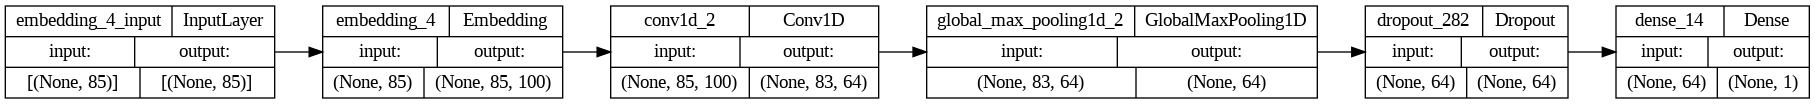

In [112]:
# Plotting the model
from keras.utils import plot_model
plot_model(
    cnn_text2,
    to_file="model_text.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [113]:
# Evaluate the performance of a CNN architecture on a test set by predicting the class
# probabilities and rounding them to obtain class predictions.

# Defines the y-prediction probability and y-prediction arrays
y_predict_proba = cnn_text2.predict(X_test)
y_predict = np.round(y_predict_proba)

# Prints classification report
print(classification_report(y_test, y_predict))

class_report = metrics.classification_report(
    y_test, y_predict, output_dict=True
)

44/44 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       198
           1       0.99      0.99      0.99      1195

    accuracy                           0.98      1393
   macro avg       0.96      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393



The provided code assesses the performance of an CNN model on a test set by predicting class probabilities and rounding them to obtain class predictions. Subsequently, it prints a classification report containing various performance metrics, such as precision, recall, F1-score, and support for each class, along with their macro and weighted averages.

According to the classification report, the model demonstrates a great level of accuracy, achieving a precision and recall of 0.94 and 0.99 for the classes. This surpasses the value of the previous CNN model by 0.1 points. The F1-score is also well performing, reaching 0.92 and 0.99 for the two classes. This score matches with the previous CNN model. The support column indicates the number of samples in each class, with class 0 has 198 samples and class 1 has 1195 samples—suggesting an unequal distribution. This also shows having a larger amount of samples leads to an overall higher performance. This model also showed very little improvement to the model. Although it improved the accuracy level slightly it is nothing noteable.

The metrics, including micro avg, macro avg, weighted avg, and samples avg, represent different averaging methods used to calculate performance metrics across all classes.

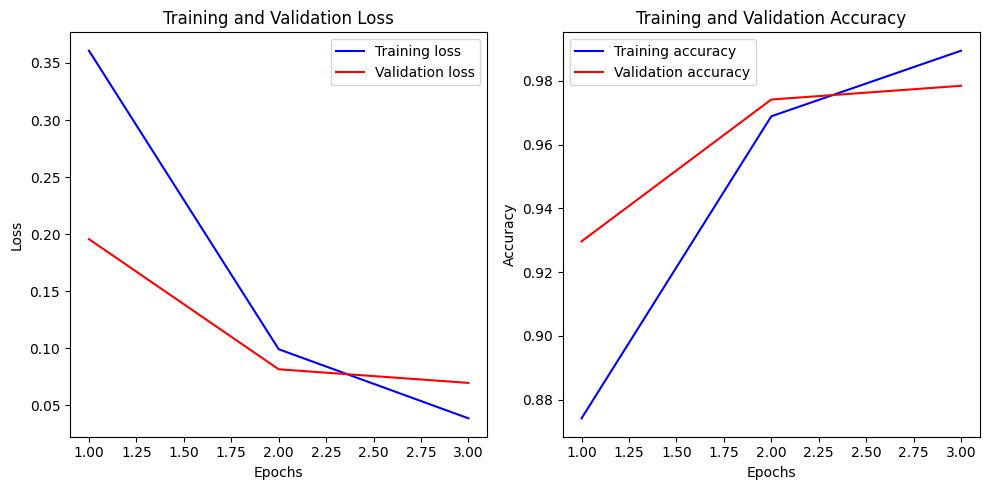

In [114]:
import matplotlib.pyplot as plt

# Get training/validation loss and accuracy from history
train_loss = cnn_history2.history['loss']
val_loss = cnn_history2.history['val_loss']
train_accuracy = cnn_history2.history['accuracy']
val_accuracy = cnn_history2.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

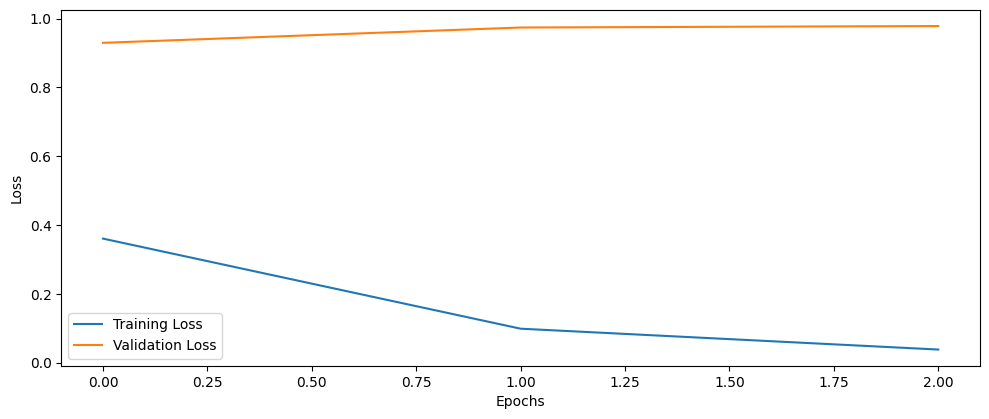

In [115]:
# Plots the training versus testing graph for the MLP model
# Model history values
hist_values = list(cnn_history2.history.values())

# Variables for plotting the training versus testing
train_loss   = hist_values[0]
train_recall = hist_values[1]
train_auc    = hist_values[2]
val_loss     = hist_values[3]


# Plots the training versus testing graph
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, (1, 2))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()

plt.show()

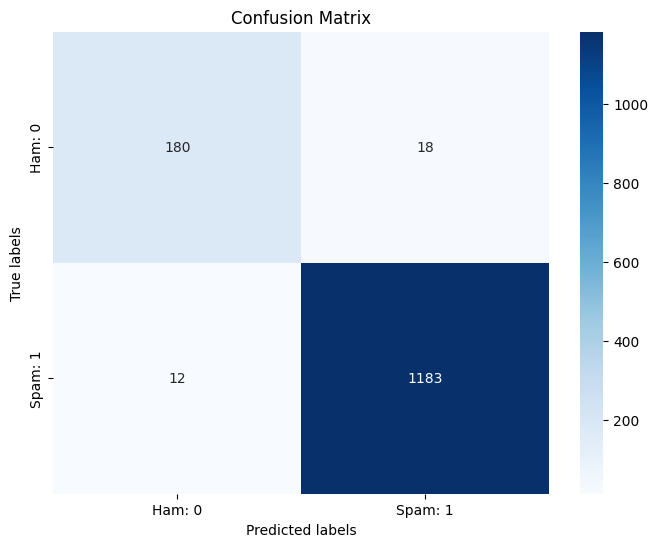

In [116]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham: 0', 'Spam: 1'], yticklabels=['Ham: 0', 'Spam: 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Sequential Network with Transformer Architecture

For the transformer Architecture we used BERT which stands for "Bidirectional Encoder Representations from Transformers." BERT is a model developed by Google that is pre-trained on textual data and is known to capture contextual information.

The provided code constructs a BERT Transformer network sourced from the Hugging Face Transformers library within TensorFlow:



Define Training Parameters:

[1]Optimizer:
-  "Adam" optimizer with a learning rate of 5e-5.

[2] Loss
- SparseCategoricalCrossentropy is used with from_logits=True, indicating that the model's output will be used directly without applying softmax.

[3] Metric
- Sparse categorical accuracy to measure the model's accuracy

We chose to use BERT the transformer for our spam ham dataset because it is proficient in capturing information due to its bidirectional nature. This means BERT is able to consider the context of both the left and right side of the word. Therefore it can help understand the relationship between the words in a sentence!

We also decided to use BERT because it is pre-trained on large amounts of text data thus allowing for transfer learning. This pre training allows the model to adapt to patterns within our dataset without requiring extensive amounts of labeled data. This allowed us to run fewer epochs on our model while still obtaining the ability to classify the messages as spam or ham!

In [23]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Convert 'ham'/'spam' to binary labels
df['Label_binary'] = df['Label'].map({'ham': 0, 'spam': 1}).astype(int)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define the maximum length
max_length = 100  # Adjust as needed

# Tokenize and encode sequences
tokenized = df['Text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_length, truncation=True))
padded = tf.keras.preprocessing.sequence.pad_sequences(tokenized, maxlen=max_length, padding='post')

# Create attention masks
attention_mask = np.where(padded != 0, 1, 0)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded, df['Label_binary'].values, test_size=0.2)
train_attention_mask, val_attention_mask, _, _ = train_test_split(attention_mask, df['Label_binary'].values, test_size=0.2)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [24]:
# Load the pre-trained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define the training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
print(model.summary())

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [25]:
# Convert the data to TensorFlow tensors
train_features = (X_train, train_attention_mask)
val_features = (X_val, val_attention_mask)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((val_features, y_val))

# Batch the datasets
train_dataset = train_dataset.shuffle(len(X_train)).batch(8, drop_remainder=True)
val_dataset = val_dataset.batch(8, drop_remainder=True)

# Train the model
history = model.fit(train_dataset, epochs=3, validation_data=val_dataset)


Epoch 1/3
557/557 [==============================] - 7644s 14s/step - loss: 0.1694 - accuracy: 0.9443 - val_loss: 0.1587 - val_accuracy: 0.9667
Epoch 2/3
557/557 [==============================] - 7251s 13s/step - loss: 0.0830 - accuracy: 0.9769 - val_loss: 0.0880 - val_accuracy: 0.9730
Epoch 3/3
557/557 [==============================] - 7187s 13s/step - loss: 0.0511 - accuracy: 0.9881 - val_loss: 0.1069 - val_accuracy: 0.9721


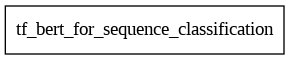

In [26]:
# Plotting the model
from keras.utils import plot_model
plot_model(
    model,
    to_file="model_bert.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

### Bert Model Evaluation and Visualization

In [35]:
predictions = model.predict(val_dataset)
predictions = predictions.logits

threshold = 0.5
predicted_labels = (predictions[:, 1] > threshold).astype(int)

# Get the true labels from the validation dataset
true_labels = []

for features, labels in val_dataset:
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)

139/139 [==============================] - 471s 3s/step


In [37]:
report = classification_report(true_labels, predicted_labels, labels=[0, 1])
print(report)

class_report = metrics.classification_report(
   true_labels, predicted_labels, output_dict=True
)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       945
           1       0.93      0.89      0.91       167

    accuracy                           0.97      1112
   macro avg       0.96      0.94      0.95      1112
weighted avg       0.97      0.97      0.97      1112



The provided code assesses the performance of our transformer model on a test set by predicting class probabilities and rounding them to obtain class predictions. Subsequently, it prints a classification report containing various performance metrics, such as precision, recall, F1-score, and support for each class, along with their macro and weighted averages.

According to the classification report, the model demonstrates a good level of accuracy, achieving a precision and recall of 0.94 and 0.98 for the classes. The F1 score is also noted to perform well, reaching 0.98 and 0.91 for the two classes. The support column indicates the number of samples in each class, with class 0 having 945 samples and class 1 having 167 samples—suggesting an unequal distribution. This also shows having a larger amount of samples leads to an overall higher performance. Therefore in our next test case we should consider splitting the data to be more equally balanced. In hopes of increasing the accuracy of the test values.

The metrics, including micro avg, macro avg, weighted avg, and samples avg, represent different averaging methods used to calculate performance metrics across all classes.

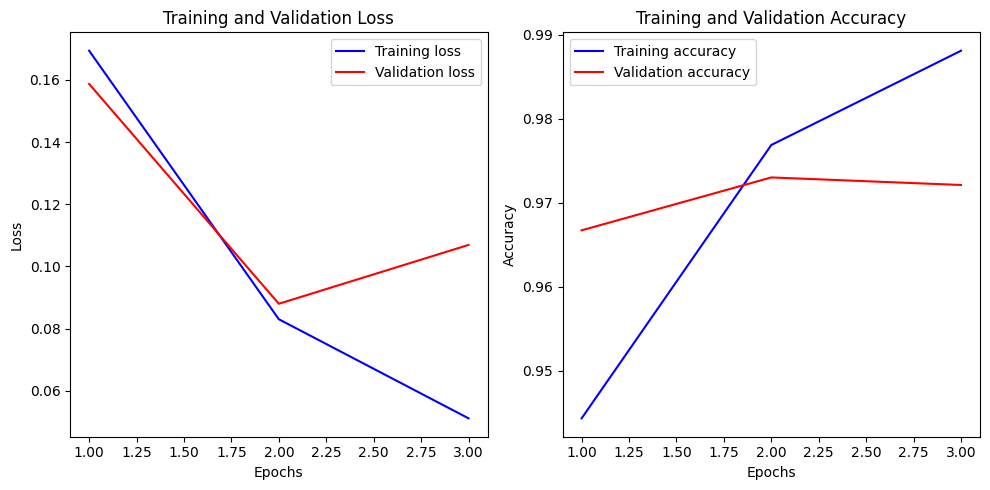

In [38]:
import matplotlib.pyplot as plt

# Get training/validation loss and accuracy from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

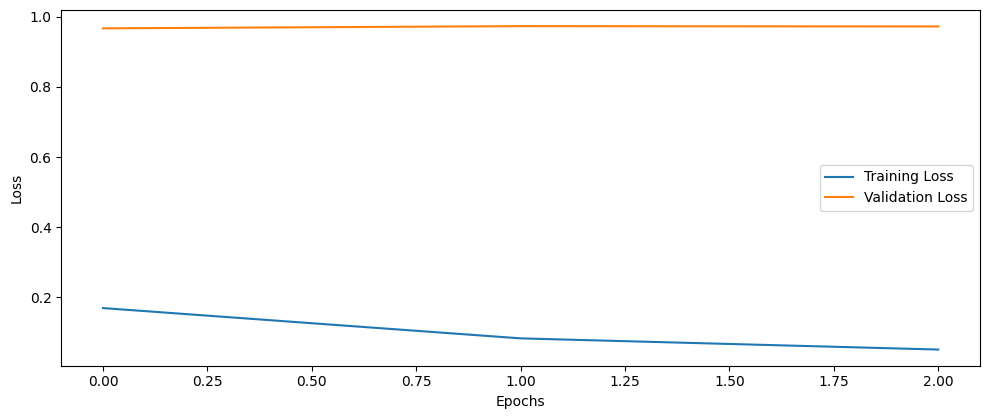

In [42]:
# Plots the training versus testing graph for the model
# Model history values
hist_values = list(history.history.values())

# Variables for plotting the training versus testing
train_loss   = hist_values[0]
train_recall = hist_values[1]
train_auc    = hist_values[2]
val_loss     = hist_values[3]


# Plots the training versus testing graph
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, (1, 2))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()

plt.show()

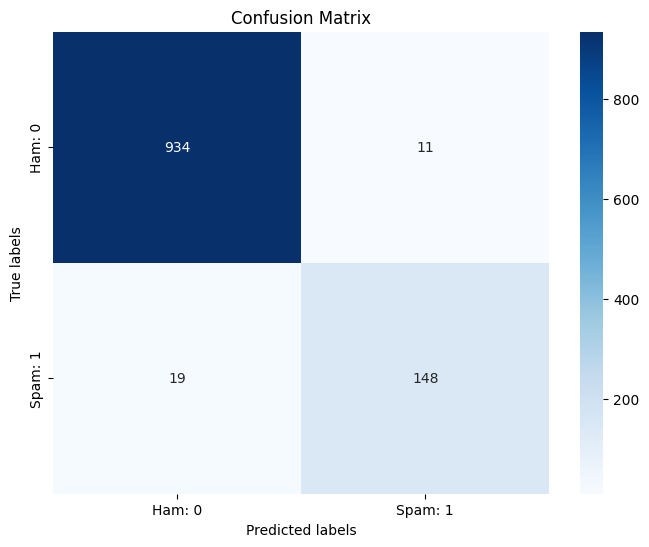

In [76]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham: 0', 'Spam: 1'], yticklabels=['Ham: 0', 'Spam: 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Adding a Second Multi-headed Self Attention Layer

By adding a second multi-headed self-attention layer we hope to capture more complex relationships and potentially capture a more fine-grained pattern. In the cells below you can see we used the model from the above analysis but added another layer. This represents that the second attention layer is the output sequence for the first attention layer.

Define Training Parameters:

[1]Input Layers:
- Two input layers
- One of shape (None, 100) and the other is the output from the first layer.

[2]Embedding Layer:
- Used for word embedding (converts discrete word indices into dense vectors)
- Input from the first input layer and outputs (None, 100, 32). (Each word becomes a 32-dimensional vector)

[3]Transformer Blocks:
- Two transformer blocks sequentially stacked on top of each other.
- Each block has its own set of parameters (transformer_block_2 and transformer_block_3).
- Each block operates on the embedded input data and retains the shape (None, 100, 32).

[4]Global Average Pooling 1D Layer:
- This layer reduces the spatial dimensions of the input by taking the average along the temporal axis (100 tokens).
- Reduces the output to (None, 32).

[5]Dropout Layers:
- Apply dropout regularization to prevent overfitting.
- Randomly drops a fraction of the input units, setting them to zero.
- Two dropout layers are used after the pooling layer and the subsequent dense layer.

[6]Dense Layers:
- Two dense layers
- The first one reduces the output to (None, 20)
- The second one reduces it to (None, 1)



In [94]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Convert 'ham'/'spam' to binary labels
df['Label_binary'] = df['Label'].map({'ham': 0, 'spam': 1}).astype(int)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define the maximum length
max_length = 100  # Adjust as needed

# Tokenize and encode sequences
tokenized = df['Text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_length, truncation=True))
padded = tf.keras.preprocessing.sequence.pad_sequences(tokenized, maxlen=max_length, padding='post')

# Create attention masks
attention_mask = np.where(padded != 0, 1, 0)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded, df['Label_binary'].values, test_size=0.2)
train_attention_mask, val_attention_mask, _, _ = train_test_split(attention_mask, df['Label_binary'].values, test_size=0.2)

In [95]:
# Load the pre-trained BERT model for sequence classification
model_multi = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define the training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile the model
model_multi.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [96]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, MultiHeadAttention, GlobalAveragePooling1D, Dense, Input, Dropout
from tensorflow.keras.models import Model
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


embed_dim = 32  # Embedding size for each token
num_heads = 2   # Number of attention heads
ff_dim = 32     # Hidden layer size in feed forward network inside transformer


inputs = Input(shape=(max_length,))
attention_masks = Input(shape=(max_length,))

embedding_layer = Embedding(input_dim=len(tokenizer.vocab), output_dim=embed_dim, input_length=max_length)
x = embedding_layer(inputs)

transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block1(x)

transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block2(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation="sigmoid")(x)

model_multi = Model(inputs=[inputs, attention_masks], outputs=outputs)
model_multi.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])



In [97]:
# Convert the data to TensorFlow tensors
train_features = (X_train, train_attention_mask)
val_features = (X_val, val_attention_mask)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((val_features, y_val))

# Batch the datasets
train_dataset = train_dataset.shuffle(len(X_train)).batch(8, drop_remainder=True)
val_dataset = val_dataset.batch(8, drop_remainder=True)

In [98]:
# Train the model
# Rerun and switch this to be model_multi

history2 = model_multi.fit(train_dataset, epochs=3, validation_data=val_dataset)

Epoch 1/3
557/557 [==============================] - 31s 47ms/step - loss: 0.1353 - accuracy: 0.9544 - val_loss: 0.0196 - val_accuracy: 0.9919
Epoch 2/3
557/557 [==============================] - 27s 49ms/step - loss: 0.0233 - accuracy: 0.9917 - val_loss: 0.0092 - val_accuracy: 0.9946
Epoch 3/3
557/557 [==============================] - 25s 44ms/step - loss: 0.0090 - accuracy: 0.9960 - val_loss: 0.0385 - val_accuracy: 0.9856


In [99]:
# Rerun and switch this to be model_multi
print(model_multi.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 100, 32)              976704    ['input_7[0][0]']             
                                                                                                  
 transformer_block_2 (Trans  (None, 100, 32)              10656     ['embedding_2[0][0]']         
 formerBlock)                                                                                     
                                                                                                  
 transformer_block_3 (Trans  (None, 100, 32)              10656     ['transformer_block_2[0]

## Evaluation and Visualizations for the Second Multi-headed Self Attention Layer

In [100]:
predictions = model.predict(val_dataset)
predictions = predictions.logits

threshold = 0.5
predicted_labels = (predictions[:, 1] > threshold).astype(int)

# Get the true labels from the validation dataset
true_labels = []

for features, labels in val_dataset:
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)

139/139 [==============================] - 534s 4s/step


In [101]:
report = classification_report(true_labels, predicted_labels, labels=[0, 1])
print(report)

class_report = metrics.classification_report(
   true_labels, predicted_labels, output_dict=True
)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       984
           1       0.97      0.91      0.94       128

    accuracy                           0.99      1112
   macro avg       0.98      0.96      0.97      1112
weighted avg       0.99      0.99      0.99      1112



The provided code assesses the performance of our transformer model on a test set by predicting class probabilities and rounding them to obtain class predictions. Subsequently, it prints a classification report containing various performance metrics, such as precision, recall, F1-score, and support for each class, along with their macro and weighted averages.

According to the classification report, the model demonstrates a great level of accuracy, achieving a precision and recall of 0.99 and 0.97 for the classes. The F1 score is also noted to perform better than the orginal transformer, reaching 0.99 and 0.94 for the two classes. The support column indicates the number of samples in each class, with class 0 having 984 samples and class 1 having 128 samples—suggesting an unequal distribution. This also shows having a larger amount of samples leads to an overall higher performance. Therefore in our next test case, we should consider splitting the data to be more equally balanced. In hopes of increasing the accuracy of the test values.

The metrics, including micro avg, macro avg, weighted avg, and samples avg, represent different averaging methods used to calculate performance metrics across all classes.

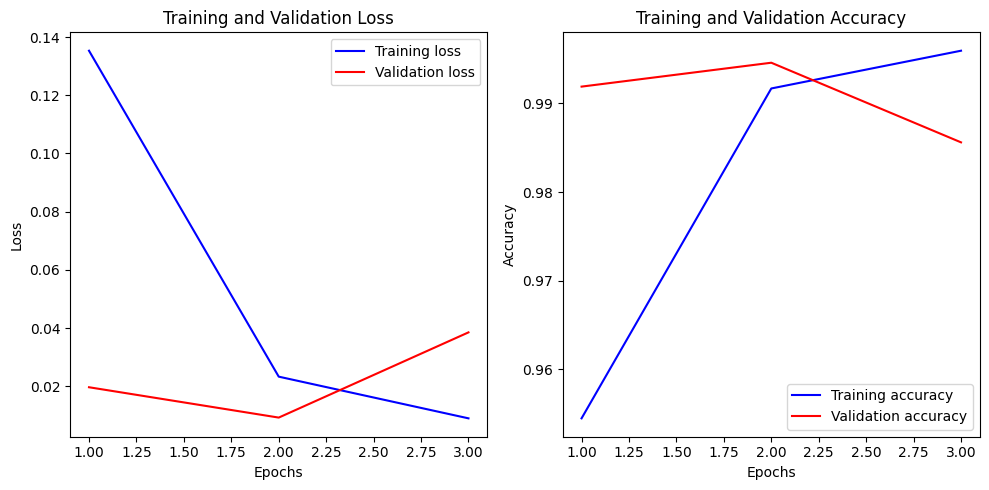

In [102]:
import matplotlib.pyplot as plt

# Get training/validation loss and accuracy from history
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

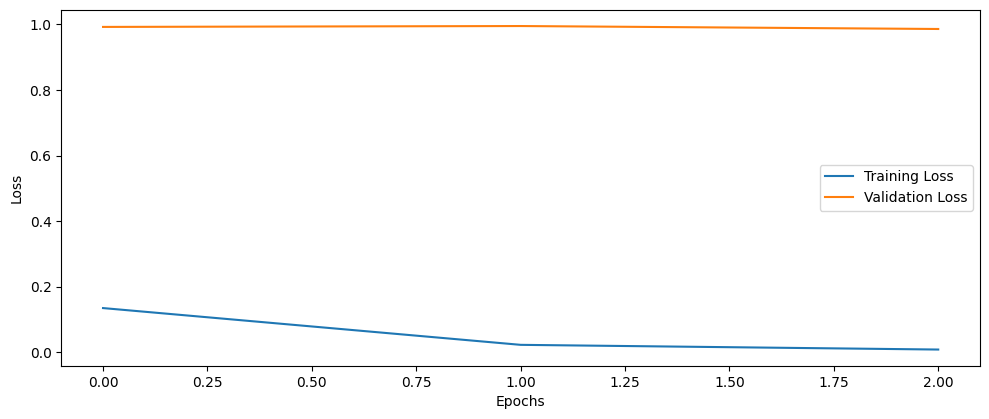

In [103]:
# Plots the training versus testing graph for the model
# Model history values
hist_values = list(history2.history.values())

# Variables for plotting the training versus testing
train_loss   = hist_values[0]
train_recall = hist_values[1]
train_auc    = hist_values[2]
val_loss     = hist_values[3]


# Plots the training versus testing graph
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, (1, 2))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()

plt.show()

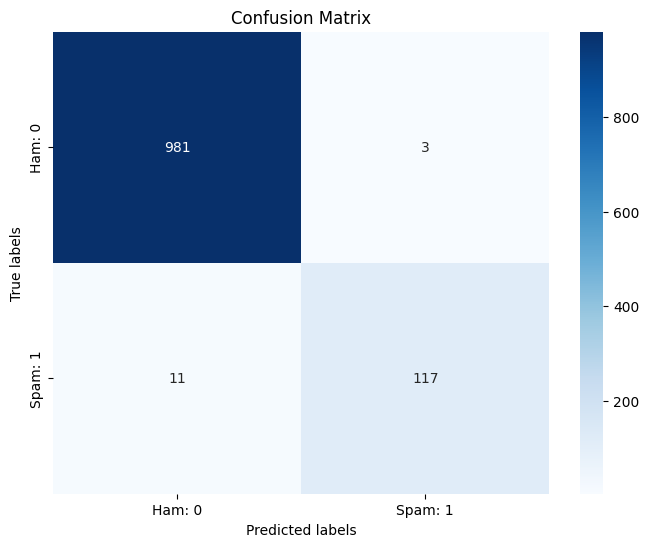

In [104]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham: 0', 'Spam: 1'], yticklabels=['Ham: 0', 'Spam: 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Exceptional Work


Use the pre-trained ConceptNet Numberbatch embedding and compare to pre-trained GloVe. Which method is better for your specific application?